# Makemore from Scratch Part 3: Activations & Gradients, BatchNorm

In this notebook, I'm following along with the YouTube video [Building makemore Part 3: Activations & Gradients, BatchNorm](https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4), where [Andrej Karpathy](https://www.youtube.com/@AndrejKarpathy) continues walking through the development and optimization of a language model from scratch.

In [84]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

print(torch.__version__)


2.0.1


In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [73]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# BEFORE
#C  = torch.randn((vocab_size, n_embd),            generator=g)
#b1 = torch.randn(n_hidden,                        generator=g)
#W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
#W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
#b2 = torch.randn(vocab_size,                      generator=g) 

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2] 
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [74]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.3135


In [79]:
h[0:3]

tensor([[ 0.5503, -0.1064, -0.6658,  0.3104, -0.1264, -0.3412, -0.3162, -0.7643,
          0.0952,  0.6966,  0.7639, -0.5076,  0.4471, -0.1396,  0.0675,  0.2194,
         -0.5301, -0.2448, -0.2487,  0.5998, -0.2357, -0.4493, -0.1108,  0.9244,
          0.4208, -0.7060,  0.5697, -0.7301, -0.0014,  0.3256, -0.7308,  0.6701,
          0.4316,  0.5717,  0.9183, -0.8962,  0.8339, -0.9038,  0.9480, -0.4041,
          0.4321, -0.4102,  0.4310, -0.6568,  0.0594,  0.8292,  0.6413,  0.0110,
         -0.6159, -0.6109, -0.5580, -0.5094, -0.8230, -0.3570, -0.9284,  0.3702,
         -0.4472, -0.7033, -0.6188, -0.5727,  0.6617,  0.2950,  0.0678, -0.4206,
          0.4295,  0.1482,  0.2087, -0.5710, -0.8604,  0.5934,  0.4548,  0.4879,
         -0.0900, -0.1468,  0.3418,  0.6085,  0.9312,  0.0977,  0.4712,  0.5743,
          0.6868,  0.7003, -0.6546, -0.8498,  0.8510, -0.8523,  0.2188, -0.3676,
         -0.3327, -0.3144, -0.2713,  0.9036, -0.7527,  0.8211, -0.7853,  0.7309,
         -0.6359, -0.7629, -

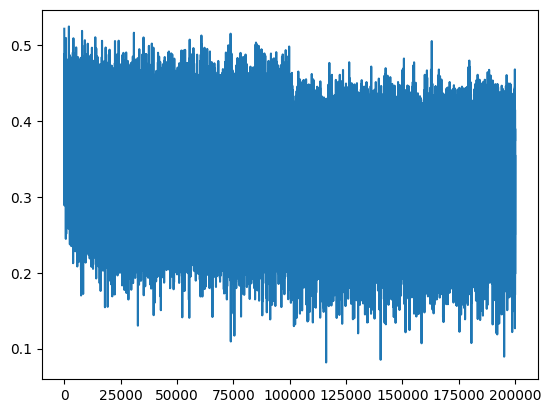

In [30]:
plt.plot(lossi)

In [31]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0695888996124268
val 2.131074905395508


In [12]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amorie.
khi.
myli.
taty.
salayson.
mahnen.
den.
art.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wazthoniearynix.
kaelissuli.


## Output Layer Softmax Initialization

The first thing we might notice is that our loss right in the first iteration is huge. It's ~27.8 and then it goes down to ~2.8 within the first 10,000 training iterations. 

```
0/ 200000: 27.8817
10000/ 200000: 2.8263
...
```

It is a reasonable expectation to assume that since we have 27 characters, that any of them should be equally as likely to start with. So we might want a more uniform distribution, assigning nearly equal probability.

In that case, the probability of any character should be $1/27$, so we can calculate the loss as:

$$
-\ln\bigg({\frac{1}{27}}\bigg) ~= 3.2958
$$

In [13]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

The problem right now is that the neural network is assigning random values during initialization that are very different for different characters. Let's simplify it down to a 4-dimensional (4 character) example to understand it better.

In [16]:
# If they're uniformly distributed, the loss is low and the same for any character
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss1 = -probs[2].log()
loss2 = -probs[0].log()
probs, loss1, loss2

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863), tensor(1.3863))

In [25]:
# If they're not nearly uniformly distributed, the loss can be huge for any character
logits = torch.tensor([3.5, 22.4, -2.1, -0.3])
probs = torch.softmax(logits, dim=0)
loss1 = -probs[2].log()
loss2 = -probs[0].log()
probs, loss1, loss2

(tensor([6.1920e-09, 1.0000e+00, 2.2897e-11, 1.3852e-10]),
 tensor(24.5000),
 tensor(18.9000))

So we want the logits to be uniformly distributed. We could set them all to $1.0$ and it would work, but it's generally good practice not to make them all positive or negative. So we'll aim to make them all $0.0$.

Logits are:
```
logits = h @ W2 + b2
```

So we can set the `b2` biases to $0$ and scale down the `W2` weights by multiplying them by a small fraction, like $0.01$. 

```
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 
```

By doing this, we get a much better starting loss:

```
0/ 200000: 3.3221
```

And it improves our overall loss after training:

```
# Before
train 2.1261181831359863
val 2.1693320274353027

# After
train 2.0695888996124268
val 2.131074905395508
```

It's ok for the biases to be set to $0$, but we don't want the weights to be set exactly to $0$, we want them to be small numbers. We want some small amount of entropy and that's used for ***symmetry breaking***. 

When our logits are uniform, we no longer have the hockey-shaped loss graph, it looks a bit more like a linear downwards descent now. 



(Note: We'll come back to how we can pick this weight multiplier in a bit.)


## Hidden Layer tanh Saturation

The pre-activated inputs to the hidden layer come from the encoded characters from the input layer times the weights W1, and then have biases added. Then, the activated layer values are stored into the hidden layer by running them through a `tanh`. 

```
hpreact = embcat @ W1 + b1 # hidden layer pre-activation
h = torch.tanh(hpreact) # hidden layer
```

The `tanh` function, short for hyperbolic tangent function, is a mathematical function often used in machine learning and neural networks. It's an activation function commonly used in the hidden layers of artificial neural networks. The "h" in "tanh" stands for "hyperbolic."

$$\tanh(x) = \frac{{e^{x} - e^{-x}}}{{e^{x} + e^{-x}}}$$

The tanh function squashes the input values to be in the range of -1 to 1. This means that if you input a large positive number, you'll get a value close to 1, and if you input a large negative number, you'll get a value close to -1.

If we break on the first iteration through our training loop and look at the hidden layer values, we can see that they look something like this. Here I just took a snapshot of the first three rows of the tensor. 

In [56]:
# The first three rows of the hidden layer tensor before we optimized it
h_snapshot = torch.tensor([[ 0.8875,  0.8216,  0.4173,  0.1257,  0.9025,  0.9998,  1.0000, -0.7560,
         -0.1272,  0.9999,  0.9002,  0.4404, -0.9692, -0.9514,  0.5833, -0.7081,
         -0.7881, -0.9963, -1.0000,  0.9999,  0.9982,  0.9326, -0.9295,  1.0000,
         -0.7855,  1.0000, -1.0000,  0.9683, -1.0000,  0.7645,  0.7537, -1.0000,
          0.9990,  0.7548, -1.0000, -0.9993, -0.0705, -1.0000,  0.9995,  0.9997,
         -0.8216, -0.9908, -0.9996, -1.0000,  0.9941,  0.9951, -0.8210, -1.0000,
          1.0000,  0.9999,  0.8558,  0.7653,  0.6301,  0.9540,  0.9200, -0.9824,
          0.9967, -0.7917,  1.0000, -0.9778, -0.9988, -0.9714, -0.7145,  0.9993,
          0.9991,  1.0000,  1.0000, -0.0816, -0.9994, -0.9888,  0.9991,  1.0000,
          1.0000, -1.0000, -1.0000,  0.9998,  0.4799,  0.9999,  1.0000, -0.8423,
          1.0000,  0.9987,  0.9967,  0.9682, -1.0000, -0.9992, -1.0000, -0.9988,
          1.0000, -0.9998,  0.9998,  0.9997,  0.9989,  1.0000,  1.0000,  0.9918,
         -1.0000, -0.9993,  0.9395, -1.0000, -0.9716,  0.2644, -1.0000,  1.0000,
         -0.9802,  1.0000, -1.0000, -1.0000,  1.0000, -0.9201,  0.9997,  0.9565,
          0.5771,  1.0000,  0.9961,  0.9997,  0.8577, -0.0562,  1.0000, -0.9096,
         -0.8996, -0.9839,  0.9998,  0.8218, -0.8399,  0.3679,  1.0000, -1.0000,
         -1.0000,  0.7032,  0.9980,  0.7170, -0.4646, -1.0000, -0.9739, -1.0000,
         -0.0986,  0.9983,  0.8468,  0.9998,  0.9998, -0.9856,  0.9113, -0.9994,
          1.0000, -0.9491, -0.6203,  0.9973,  0.7848,  1.0000,  0.9999, -0.9976,
          0.9973,  1.0000,  0.9935, -1.0000,  0.9875,  0.4617, -0.9999, -0.8689,
          0.9944,  1.0000, -0.0919, -1.0000,  0.9999, -0.9998, -0.1415,  0.9593,
         -1.0000, -0.9870, -0.5458,  0.2058,  0.9989, -0.9995,  0.3378,  0.9994,
          0.9999, -1.0000, -0.5531, -0.9997,  0.9959, -0.9924, -1.0000,  1.0000,
          0.9764,  0.1841,  0.9984, -0.9986,  1.0000,  0.9988,  0.9998,  1.0000,
         -0.9639,  0.9423, -1.0000,  0.9999,  0.9997, -1.0000,  1.0000,  1.0000],
        [ 1.0000, -0.7452,  0.1943, -0.9965,  0.9953, -0.9990,  0.9994,  0.9929,
          1.0000,  0.9418, -0.5072,  1.0000,  0.9156,  1.0000, -0.9997, -0.9984,
          1.0000, -1.0000, -1.0000,  1.0000, -0.2759,  0.7430,  1.0000,  0.8952,
         -0.9998, -0.9995, -0.9994,  0.9996,  0.9994, -0.9949, -0.4717, -1.0000,
         -1.0000, -0.9999, -0.9570,  1.0000,  0.9221, -0.9987, -0.9550, -0.9977,
          0.9994, -1.0000,  0.9539, -1.0000, -0.7640, -0.9967, -0.9999, -0.9996,
          1.0000, -0.8658, -0.5081,  0.9141,  0.3270, -0.3815,  0.9923, -1.0000,
          0.9975,  1.0000, -1.0000,  1.0000, -0.9995, -0.9977, -0.9034, -1.0000,
          1.0000,  1.0000, -0.6969, -0.9987, -1.0000, -1.0000,  0.9975,  1.0000,
          0.9067, -0.9992, -1.0000, -0.9980, -0.7856,  0.9353, -0.8665,  0.9688,
          0.9956,  1.0000,  0.9979,  0.9991, -0.9969, -0.9998, -0.9955, -0.7811,
          0.0946, -0.9989,  1.0000,  0.9289, -0.9898, -0.7238,  0.9270, -0.6104,
          0.5848,  0.2574,  0.9982, -1.0000, -0.7846,  0.8855, -1.0000, -0.0401,
         -1.0000,  1.0000, -0.9352, -0.9987,  0.9999,  0.1236,  1.0000,  0.8241,
          0.7718,  0.9307,  1.0000, -0.9891,  0.9393,  0.9985,  0.9999,  1.0000,
          0.9999, -0.9997,  1.0000,  0.9994,  0.8953, -0.1001, -0.9890, -1.0000,
         -0.9999,  0.9984,  1.0000, -0.9968, -1.0000, -0.7744,  1.0000, -1.0000,
         -1.0000,  1.0000,  1.0000, -0.6065,  1.0000, -0.7202, -1.0000, -0.2345,
          1.0000,  0.0387, -0.9916,  1.0000, -0.8741,  0.9974, -0.9534,  0.8594,
          0.9999,  1.0000,  0.9998,  0.9954,  0.9995,  0.9931, -0.9846, -0.9355,
          1.0000,  0.9824, -0.8598, -0.9998,  0.9997,  0.9980, -0.8409,  1.0000,
         -0.9958, -1.0000, -0.9900,  0.9943,  0.8988,  0.9992, -0.9771,  0.9984,
          0.9960, -0.9996,  0.0477, -1.0000,  0.9999, -0.9998, -0.9923,  1.0000,
          0.8414,  1.0000,  1.0000,  0.8391,  0.9930, -0.2513, -1.0000,  1.0000,
         -0.9408,  0.9970, -1.0000,  0.9618,  0.9990, -0.9689,  1.0000, -0.7182],
        [-0.9997, -1.0000, -1.0000, -0.9045,  1.0000,  1.0000,  0.9999,  0.9769,
         -1.0000, -0.9476, -1.0000, -0.9648,  0.9968, -1.0000,  1.0000,  0.9962,
          0.5153, -1.0000, -1.0000,  0.9832,  1.0000, -0.9624,  1.0000, -0.9918,
          0.8209,  0.9846,  0.2577,  0.8390,  0.9997,  0.9995, -0.9998,  0.7509,
         -1.0000, -0.9937, -1.0000,  0.9755, -0.9967, -0.9989, -0.8459,  0.9998,
         -0.3626, -1.0000, -0.9651, -1.0000, -0.9974, -0.7681,  0.9800, -1.0000,
          1.0000,  1.0000,  1.0000, -0.9983,  1.0000,  1.0000,  1.0000, -0.9693,
         -0.9037,  1.0000,  1.0000, -0.9897, -1.0000, -0.4729,  1.0000,  0.8148,
          1.0000,  1.0000,  1.0000,  1.0000, -0.9968,  1.0000, -1.0000,  1.0000,
          1.0000, -0.9918, -1.0000, -1.0000,  0.9962, -1.0000, -1.0000, -1.0000,
         -0.9994,  1.0000,  1.0000, -0.9947, -1.0000, -1.0000,  0.9999, -0.9689,
          1.0000, -0.9984,  1.0000,  0.2494,  0.9695, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9974, -0.9955,  0.9960,  0.9137, -1.0000,  0.9949,
         -1.0000, -0.5375, -1.0000, -0.9998,  0.0563,  0.4098,  0.9976,  1.0000,
         -0.9910,  0.9806,  1.0000,  0.9992, -0.9999, -1.0000,  0.9999,  0.9326,
         -1.0000,  1.0000, -0.9687,  1.0000,  0.9913,  0.2430, -0.8521, -1.0000,
          0.9631,  1.0000,  1.0000,  0.7736,  0.6309,  1.0000,  0.9945,  0.8283,
          1.0000,  0.3362,  1.0000,  0.9990,  1.0000, -0.9929, -0.9997, -0.9611,
          1.0000, -1.0000, -1.0000, -0.7391,  1.0000,  0.6057,  0.7636, -0.9873,
          1.0000,  1.0000, -0.9918, -0.9999,  0.9792, -0.9990, -0.9987,  0.9994,
          0.9998,  0.9998,  0.7791, -1.0000, -1.0000, -0.9597,  0.8590, -0.9886,
         -1.0000,  0.8040, -1.0000, -1.0000,  0.9999,  0.9988, -0.9994,  1.0000,
          1.0000, -1.0000, -0.9999, -0.9942,  0.9334,  1.0000, -1.0000,  1.0000,
          0.9979, -1.0000,  1.0000,  0.6230,  1.0000,  0.0721,  0.9542,  1.0000,
          0.9518,  1.0000, -1.0000, -1.0000,  1.0000,  0.9998,  0.6848, -1.0000]])

If we flatten this and throw this into a histogram, we can see that there are a lot of values that are set to the max of -1 and 1. So the tanh is very active. 

(array([204.,  12.,   5.,   9.,   3.,   9.,   5.,   4.,   0.,   3.,   0.,
          3.,   2.,   3.,   0.,   2.,   0.,   0.,   2.,   1.,   0.,   2.,
          4.,   3.,   0.,   1.,   3.,   1.,   2.,   2.,   1.,   5.,   0.,
          3.,   1.,   2.,   3.,   1.,   0.,   3.,   4.,   0.,   3.,   4.,
          7.,   9.,   6.,  12.,  19., 232.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

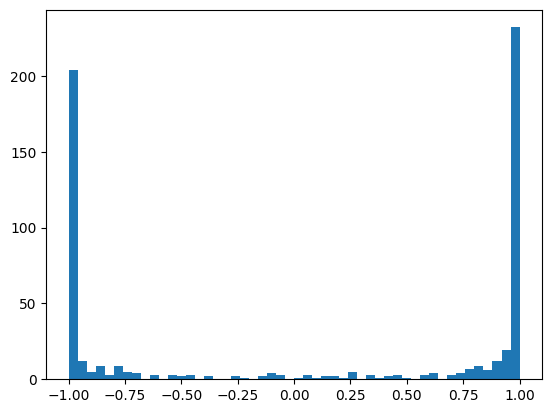

In [57]:
plt.hist(h_snapshot.view(-1).tolist(), 50)

Likewise, we can throw the preactivations (before the tanh) for the hidden layer into a histogram. Again, here is a snapshot of the first three rows of the hidden layer preactivation tensor.

In [59]:
hpreact_snapshot = torch.tensor([[  1.4103,   1.1618,   0.4444,   0.1263,   1.4858,   4.6847,   6.3573,
          -0.9867,  -0.1279,   4.9796,   1.4733,   0.4727,  -2.0791,  -1.8465,
           0.6675,  -0.8833,  -1.0664,  -3.1439,  -8.7359,   5.0966,   3.5153,
           1.6776,  -1.6549,   6.2058,  -1.0595,   5.9105,  -6.1273,   2.0643,
          -5.7645,   1.0070,   0.9815,  -8.6175,   3.7930,   0.9840, -11.2216,
          -3.9834,  -0.0706,  -5.8541,   4.1396,   4.3861,  -1.1617,  -2.6895,
          -4.1998, -11.6342,   2.9096,   3.0042,  -1.1598,  -9.1515,   7.2151,
           5.1971,   1.2775,   1.0089,   0.7415,   1.8750,   1.5892,  -2.3624,
           3.2025,  -1.0760,   7.5082,  -2.2437,  -3.7031,  -2.1157,  -0.8964,
           3.9900,   3.8416,   9.8484,   5.5433,  -0.0817,  -4.0309,  -2.5896,
           3.8557,   5.7765,   6.4791,  -5.4908,  -6.0204,   4.6469,   0.5229,
           5.1242,   5.6010,  -1.2289,   6.4926,   3.6539,   3.1958,   2.0626,
          -9.4156,  -3.9041,  -6.7843,  -3.7257,   9.8423,  -4.5870,   4.6051,
           4.4182,   3.7381,   6.6844,   7.9585,   2.7494,  -5.9146,  -3.9889,
           1.7334, -15.1666,  -2.1196,   0.2709,  -6.8024,   6.0980,  -2.3038,
           5.6320,  -9.5492,  -7.8260,   9.7644,  -1.5899,   4.3678,   1.9034,
           0.6581,   7.1940,   3.1253,   4.4670,   1.2846,  -0.0563,   5.6191,
          -1.5250,  -1.4701,  -2.4057,   4.6273,   1.1623,  -1.2207,   0.3859,
           6.4652,  -5.6123,  -5.7039,   0.8736,   3.4410,   0.9014,  -0.5032,
          -9.3102,  -2.1622,  -5.9595,  -0.0989,   3.5344,   1.2447,   4.5740,
           4.6023,  -2.4628,   1.5351,  -4.0954,  15.1002,  -1.8226,  -0.7255,
           3.2979,   1.0577,   6.8832,   5.1464,  -3.3612,   3.3004,   8.3814,
           2.8646,  -6.6101,   2.5327,   0.4994,  -4.9673,  -1.3285,   2.9412,
           9.8386,  -0.0921, -16.6868,   5.1574,  -4.6201,  -0.1424,   1.9376,
         -10.1294,  -2.5166,  -0.6124,   0.2088,   3.7571,  -4.1695,   0.3517,
           4.0343,   5.1522,  -5.7959,  -0.6228,  -4.3591,   3.0975,  -2.7853,
          -5.7492,   7.2626,   2.2133,   0.1863,   3.5695,  -3.6452,  14.6664,
           3.7270,   4.6979,   7.8102,  -1.9983,   1.7586,  -5.7295,   4.9019,
           4.4840, -10.6608,   7.4389,  10.5930],
        [  6.9137,  -0.9622,   0.1968,  -3.1697,   3.0302,  -3.8096,   4.0874,
           2.8167,   9.3566,   1.7540,  -0.5590,  10.0900,   1.5610,   9.7297,
          -4.4023,  -3.5693,   8.0668,  -9.2414,  -7.3687,  12.7160,  -0.2832,
           0.9571,   8.5857,   1.4473,  -4.6553,  -4.1484,  -4.0902,   4.2117,
           4.0569,  -2.9874,  -0.5123,  -7.3531,  -7.2515,  -5.0048,  -1.9091,
           5.9393,   1.6030,  -3.6527,  -1.8855,  -3.3931,   4.0627,  -7.4633,
           1.8737, -12.2008,  -1.0059,  -3.2019,  -4.9088,  -4.2439,   6.6113,
          -1.3162,  -0.5601,   1.5521,   0.3395,  -0.4019,   2.7768,  -6.9387,
           3.3334,   7.8994,  -7.5351,   6.8732,  -4.0997,  -3.3848,  -1.4906,
          -7.1311,   6.1411,  10.8372,  -0.8612,  -3.6513,  -9.1274, -12.9160,
           3.3359,   8.2869,   1.5087,  -3.9391,  -7.5702,  -3.4441,  -1.0599,
           1.6994,  -1.3190,   2.0717,   3.0629,   6.0749,   3.4375,   3.8571,
          -3.2332,  -4.6593,  -3.0507,  -1.0482,   0.0949,  -3.7376,  13.9642,
           1.6501,  -2.6355,  -0.9157,   1.6367,  -0.7095,   0.6698,   0.2633,
           3.5178,  -8.9839,  -1.0572,   1.4006,  -6.5282,  -0.0401,  -5.6048,
           5.8248,  -1.6980,  -3.6588,   4.9590,   0.1242,   7.1665,   1.1695,
           1.0249,   1.6636,   6.4457,  -2.6055,   1.7324,   3.6068,   4.9398,
           5.7784,   5.2727,  -4.4519,   5.6570,   4.0463,   1.4480,  -0.1004,
          -2.6002,  -5.7294,  -4.9201,   3.5661,   5.9588,  -3.2150, -11.7758,
          -1.0312,   6.7874,  -9.2078,  -7.4124,   8.9927,   9.6282,  -0.7034,
           7.2265,  -0.9080,  -7.2702,  -0.2389,   9.8125,   0.0388,  -2.7352,
           5.3556,  -1.3503,   3.3265,  -1.8676,   1.2911,   5.0559,  12.4992,
           4.7378,   3.0379,   4.1276,   2.8305,  -2.4299,  -1.7009,   8.1981,
           2.3623,  -1.2926,  -4.5093,   4.3708,   3.4548,  -1.2243,   6.5062,
          -3.0844,  -7.3588,  -2.6461,   2.9292,   1.4657,   3.8891,  -2.2292,
           3.5547,   3.1066,  -4.2029,   0.0477,  -5.4419,   4.8442,  -4.5599,
          -2.7761,   6.2838,   1.2259,   7.3910,  13.8478,   1.2183,   2.8231,
          -0.2568, -10.5982,  13.3420,  -1.7446,   3.2515,  -6.1285,   1.9700,
           3.8060,  -2.0743,   6.0166,  -0.9038],
        [ -4.4395,  -8.7848,  -6.3951,  -1.4965,  10.4013,  10.3062,   4.9924,
           2.2243,  -7.5734,  -1.8078,  -6.5693,  -2.0117,   3.2141,  -5.6278,
          11.1031,   3.1365,   0.5699,  -5.7345, -17.4775,   2.3851,  11.3215,
          -1.9769,   5.7537,  -2.7491,   1.1595,   2.4298,   0.2636,   1.2177,
           4.4553,   4.1888,  -4.6080,   0.9750, -18.7592,  -2.8764,  -7.0423,
           2.1941,  -3.2028,  -3.7566,  -1.2417,   4.6286,  -0.3799, -16.2374,
          -2.0153,  -7.3393,  -3.3279,  -1.0157,   2.2984,  -8.9864,  12.8241,
          13.0698,   7.5477,  -3.5282,   6.5518,   9.5079,  11.6634,  -2.0801,
          -1.4922,   9.3173,  17.5723,  -2.6341,  -6.0645,  -0.5138,   6.7084,
           1.1412,  12.9489,   6.9141,  12.5087,   5.3762,  -3.2142,   8.9026,
          -7.7826,  13.5712,  16.3132,  -2.7440,  -6.2337,  -5.5463,   3.1301,
          -8.1017, -11.3957,  -6.5415,  -4.0767,  11.6901,   5.9195,  -2.9664,
          -9.1313, -10.5449,   4.7913,  -2.0740,   6.3524,  -3.5718,   7.4746,
           0.2548,   2.0845, -19.9024,  -5.4567, -14.9906, -21.9361, -10.2970,
          -3.3301,  -3.0473,   3.1046,   1.5496,  -8.8403,   2.9861,  -5.7761,
          -0.6007,  -9.0762,  -4.4993,   0.0563,   0.4354,   3.3708,  13.4089,
          -2.6977,   2.3124,   7.3339,   3.8843,  -4.8519,  -7.2179,   5.0273,
           1.6780,  -8.5384,   9.4477,  -2.0715,  14.0176,   2.7194,   0.2480,
          -1.2638, -12.1430,   1.9868,   6.8859,   8.9224,   1.0292,   0.7428,
           5.3238,   2.9500,   1.1827,   8.8111,   0.3498,   6.3481,   3.7958,
           9.1075,  -2.8154,  -4.4521,  -1.9607,  11.0319, -11.4146, -12.4224,
          -0.9485,   7.1876,   0.7021,   1.0048,  -2.5281,   9.6641,  11.7825,
          -2.7468,  -4.8405,   2.2767,  -3.7936,  -3.6576,   4.0630,   4.6334,
           4.6292,   1.0430, -19.0180,  -6.3180,  -1.9415,   1.2894,  -2.5800,
          -8.7983,   1.1099,  -7.2138,  -9.1753,   5.0651,   3.6955,  -4.0353,
           5.5840,  16.0996, -19.7428,  -5.2519,  -2.9232,   1.6842,   9.2184,
          -5.9239,   7.1967,   3.4331,  -5.4459,  13.1177,   0.7299,  17.9615,
           0.0722,   1.8768,   6.1249,   1.8503,   7.7968, -14.9972,  -7.7294,
          16.8825,   4.5300,   0.8381,  -5.4262]])

(array([ 1.,  0.,  2.,  2.,  0.,  1.,  1.,  1.,  3.,  0.,  0.,  2.,  4.,
         3.,  5.,  6., 12.,  5., 17., 11., 22., 18., 27., 25., 34., 29.,
        32., 32., 34., 41., 17., 39., 28., 31., 19., 20., 18.,  8.,  6.,
        13.,  4.,  4.,  3.,  7.,  5.,  2.,  1.,  2.,  1.,  2.]),
 array([-21.93610001, -21.138148  , -20.340196  , -19.542244  ,
        -18.74429199, -17.94633999, -17.14838799, -16.35043598,
        -15.55248398, -14.75453197, -13.95657997, -13.15862797,
        -12.36067596, -11.56272396, -10.76477196,  -9.96681995,
         -9.16886795,  -8.37091595,  -7.57296394,  -6.77501194,
         -5.97705994,  -5.17910793,  -4.38115593,  -3.58320393,
         -2.78525192,  -1.98729992,  -1.18934792,  -0.39139591,
          0.40655609,   1.20450809,   2.0024601 ,   2.8004121 ,
          3.59836411,   4.39631611,   5.19426811,   5.99222012,
          6.79017212,   7.58812412,   8.38607613,   9.18402813,
          9.98198013,  10.77993214,  11.57788414,  12.37583614,
         13.

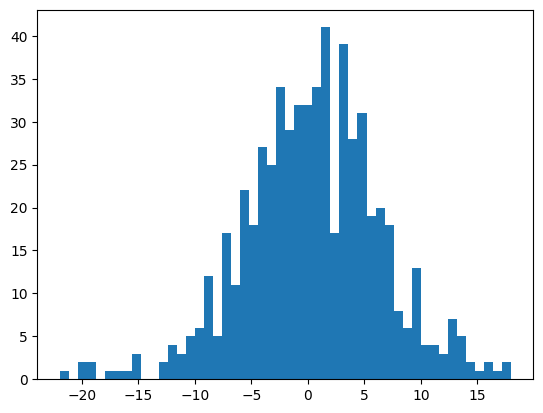

In [60]:
plt.hist(hpreact_snapshot.view(-1).tolist(), 50)

Now we can see that the reason why is that we have a very broad distribution with very large values that will definitely result in -1 and +1 when we pass them through the `tanh` function.

Why is this bad? 

During back propagation, we're going to back propagate through the `tanh`. The gradient for `tanh` looks something like this:

```
self.grad += (1 - t**2) * out.grad
```

The value of `t` can be between -1 and 1. 

If the value for `t` is exactly 0, then `out.grad` is just passed through and the tanh is effectively having no impact. 

But, if our activated value `t` is 1 or -1, the whole term will come out as 0, and it won't have any impact on the loss.

The gradient flowing through `tanh` can only ever decrease, so once we get to -1 or 1, it basically gets "stuck" there. 

So if all the outputs h are in the flat region of -1 or 1, then the gradients will all get destroyed at this layer. 

We can quickly visualize what it looks like here. Again, I'm only look at the first three rows of our layer with 200 neurons, so this is an incomplete picture. The actual shape is 32 x 200.

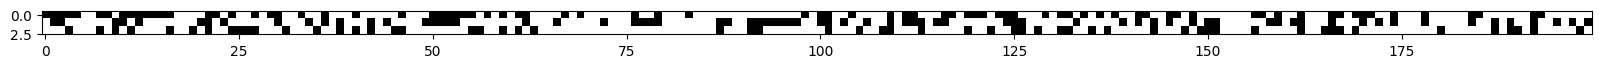

In [61]:
plt.figure(figsize=(20,10))
plt.imshow(h_snapshot.abs() > 0.99, cmap='gray', interpolation='nearest')

Each column represents one of our 200 neurons in our layer, so if the entire column was white then we'd have a "dead neuron". This is the case in this small snapshot of the first three rows, but not when we look at the entire 32 rows across all of our neurons.

We don't have any dead neurons in our system, so we are going to continue learning and adjusting loss, but the fact that we're starting out the network with such extreme values is not ideal. 

> Note: Other activation functions like Sigmoid, ReLU, Maxout, and ELU could also encounter this same issue, so knowing how to identify, diagnose, and resolve it is helpful in general. Some non-linearities like Leaky ReLU might not suffer as much because they don't flatten out in the same way.

So, to solve this we're going to do something similar and adjust the parameters that feed into the pre-activated hidden layer:

```
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
```

We can set the bias to 0, but it's good to set it to something small so that there is a bit of entropy. Now let's look at the visualizations after setting these values.

In [80]:
h_snapshot = torch.tensor([[ 0.5503, -0.1064, -0.6658,  0.3104, -0.1264, -0.3412, -0.3162, -0.7643,
          0.0952,  0.6966,  0.7639, -0.5076,  0.4471, -0.1396,  0.0675,  0.2194,
         -0.5301, -0.2448, -0.2487,  0.5998, -0.2357, -0.4493, -0.1108,  0.9244,
          0.4208, -0.7060,  0.5697, -0.7301, -0.0014,  0.3256, -0.7308,  0.6701,
          0.4316,  0.5717,  0.9183, -0.8962,  0.8339, -0.9038,  0.9480, -0.4041,
          0.4321, -0.4102,  0.4310, -0.6568,  0.0594,  0.8292,  0.6413,  0.0110,
         -0.6159, -0.6109, -0.5580, -0.5094, -0.8230, -0.3570, -0.9284,  0.3702,
         -0.4472, -0.7033, -0.6188, -0.5727,  0.6617,  0.2950,  0.0678, -0.4206,
          0.4295,  0.1482,  0.2087, -0.5710, -0.8604,  0.5934,  0.4548,  0.4879,
         -0.0900, -0.1468,  0.3418,  0.6085,  0.9312,  0.0977,  0.4712,  0.5743,
          0.6868,  0.7003, -0.6546, -0.8498,  0.8510, -0.8523,  0.2188, -0.3676,
         -0.3327, -0.3144, -0.2713,  0.9036, -0.7527,  0.8211, -0.7853,  0.7309,
         -0.6359, -0.7629, -0.6201, -0.8339, -0.5615,  0.6025,  0.4339, -0.9475,
         -0.6802,  0.9490,  0.7132, -0.2674,  0.9834, -0.5872,  0.7395,  0.3657,
         -0.7835,  0.8891, -0.7286, -0.9784, -0.1518, -0.2623,  0.5123,  0.6269,
          0.8728,  0.7600, -0.0965, -0.3175, -0.4380,  0.0760, -0.9547, -0.3893,
          0.8326,  0.1050, -0.1599, -0.9274, -0.8227,  0.3006, -0.1848,  0.2928,
         -0.7761, -0.6947,  0.2424,  0.6068, -0.2880, -0.9161, -0.5152,  0.9610,
         -0.4524,  0.8662,  0.3073,  0.8221,  0.8398, -0.8955, -0.7611,  0.8864,
          0.5933,  0.5719, -0.1485, -0.2055,  0.6010, -0.0313, -0.4673, -0.5484,
         -0.0911,  0.6570,  0.8271,  0.5480,  0.8754,  0.8090,  0.7230,  0.5397,
         -0.4144, -0.3906,  0.6082, -0.7859, -0.8629,  0.6636, -0.8518, -0.5035,
         -0.7498,  0.8346,  0.3602,  0.2747,  0.2741, -0.3631,  0.9666, -0.7665,
          0.1010, -0.4286,  0.9657,  0.2864, -0.9152, -0.8504,  0.5289, -0.9407,
         -0.7521, -0.6119,  0.7980,  0.2909, -0.9631, -0.3477, -0.9756,  0.8880],
        [-0.9081, -0.1924, -0.1833, -0.2285, -0.8394, -0.8400,  0.5554,  0.1445,
         -0.4109,  0.6946, -0.2596, -0.2951, -0.7926,  0.5612, -0.4815, -0.7590,
          0.7486, -0.7038,  0.6073,  0.7771, -0.9644, -0.8518, -0.1701, -0.2088,
          0.5043,  0.6411,  0.0170, -0.4139,  0.8119,  0.1582,  0.8742,  0.5940,
         -0.1457, -0.5095,  0.5576, -0.3750,  0.0072, -0.8051, -0.1009, -0.9177,
          0.3987, -0.0772,  0.6348, -0.0657, -0.3562,  0.2116, -0.0072, -0.2513,
          0.4406,  0.3058, -0.1879,  0.6336,  0.4721, -0.0224,  0.2561, -0.0048,
         -0.3102, -0.2937,  0.3782,  0.6874,  0.6845,  0.0867,  0.7453, -0.2580,
         -0.8794, -0.4814,  0.7610, -0.0370, -0.8926, -0.2761,  0.3924, -0.0239,
         -0.2782, -0.7531, -0.7093,  0.6797,  0.2352, -0.8945, -0.0551,  0.5132,
          0.6343,  0.6772,  0.4996,  0.8639, -0.4637,  0.1867, -0.3036, -0.0146,
          0.0339, -0.2680,  0.6600,  0.6877, -0.4524, -0.6663,  0.3723,  0.4272,
          0.2836, -0.6723, -0.8917,  0.0516, -0.9315,  0.1830, -0.9433, -0.4290,
          0.3946,  0.6446, -0.6032, -0.1485,  0.7295,  0.9304,  0.1501,  0.6641,
          0.2574, -0.8773, -0.9165,  0.8540, -0.3389, -0.7625, -0.0498,  0.5465,
         -0.1690,  0.7927,  0.5248,  0.4337, -0.6241,  0.9833,  0.5962, -0.1466,
          0.3169, -0.5727,  0.9443,  0.1765, -0.9934,  0.7929, -0.7921, -0.7690,
         -0.8082, -0.7678, -0.7152, -0.4143, -0.8079, -0.4626, -0.9445, -0.5786,
          0.7982,  0.5406, -0.3397,  0.7639,  0.6553, -0.5422, -0.2616, -0.7321,
         -0.7253,  0.9209,  0.5762,  0.7708,  0.9623, -0.5624, -0.0309,  0.2825,
          0.7134,  0.2508, -0.2229, -0.3495,  0.2987, -0.3539, -0.7110, -0.0747,
         -0.4162, -0.6048,  0.6678,  0.2250, -0.9089,  0.0188,  0.8403, -0.1943,
         -0.6879, -0.2784, -0.5053, -0.2665,  0.7807, -0.8087, -0.8393, -0.3648,
          0.7766,  0.6679,  0.2414, -0.0038, -0.8821,  0.8720,  0.1147,  0.5323,
          0.7772,  0.0073, -0.4103, -0.2879, -0.0623,  0.0494,  0.4942,  0.4397],
        [ 0.8016,  0.1173,  0.8237,  0.2816,  0.9870,  0.3072,  0.4912, -0.3553,
          0.6042,  0.1462, -0.5563,  0.3315,  0.6037,  0.8469, -0.4705, -0.9445,
          0.9866, -0.2081, -0.7619,  0.9202,  0.6015,  0.0707,  0.4040, -0.2889,
         -0.9087,  0.2751, -0.8610,  0.4583,  0.6388,  0.7639, -0.7246, -0.7441,
         -0.7803, -0.0754, -0.9124, -0.1469,  0.8119, -0.0846, -0.5637,  0.4540,
         -0.8029, -0.8601, -0.7286, -0.9512, -0.3908, -0.8333, -0.8038, -0.1140,
          0.7740,  0.1578, -0.6202, -0.6470,  0.2918, -0.4030,  0.0319, -0.9772,
         -0.2730,  0.9877, -0.0180, -0.1743, -0.7990,  0.5017, -0.6174, -0.1383,
          0.8100,  0.8928,  0.5618,  0.5730, -0.7151, -0.4541,  0.4765,  0.7807,
          0.7138, -0.0806, -0.8488,  0.2584,  0.8730, -0.4829, -0.9306,  0.6813,
         -0.6687,  0.9114,  0.9333,  0.5778,  0.1475,  0.1005,  0.5353, -0.8839,
          0.1403, -0.8668,  0.8899,  0.0120, -0.8256, -0.8254, -0.5651, -0.7983,
         -0.1039, -0.6022,  0.7900, -0.7742, -0.1313,  0.8405, -0.7760, -0.5248,
          0.0340,  0.2686, -0.9232, -0.7985, -0.2772, -0.2268,  0.6551,  0.3725,
          0.3043,  0.9509,  0.7663, -0.1310,  0.1122,  0.4653,  0.8844, -0.3176,
          0.5703, -0.5733,  0.8773,  0.3364,  0.4836, -0.2776, -0.2998, -0.8297,
         -0.9077,  0.8985,  0.7583, -0.6731, -0.4449,  0.3888,  0.9165, -0.3453,
         -0.6380,  0.7274,  0.9437,  0.8129,  0.8765, -0.2793, -0.3619,  0.7263,
         -0.5422,  0.3846, -0.9818,  0.0364, -0.3712,  0.4383,  0.6887,  0.1445,
          0.8922,  0.9510,  0.4820,  0.2258, -0.5236, -0.4393,  0.8905,  0.9163,
          0.4488,  0.7278, -0.0261, -0.9730,  0.2642, -0.3090,  0.1865,  0.9183,
          0.4150, -0.8370, -0.8375, -0.0054,  0.7118,  0.6682, -0.5900,  0.8918,
          0.9422, -0.9355, -0.1359, -0.9196,  0.4569,  0.1288, -0.7132,  0.9383,
          0.4309,  0.4099,  0.9565, -0.4468,  0.6935, -0.3151, -0.5186,  0.8630,
         -0.8307,  0.7012, -0.1471,  0.7499,  0.6636,  0.2890,  0.6476,  0.8827]])

(array([ 9., 17., 15., 16., 17., 18., 12., 11.,  9., 12., 12.,  8.,  9.,
        12., 13.,  9., 11., 14., 18.,  7.,  8., 15.,  9.,  8., 12., 11.,
         7.,  8.,  9.,  6.,  6., 10., 18.,  5.,  9., 12., 14.,  9., 11.,
        12., 15., 20., 13., 14., 14., 16., 12., 19., 16., 13.]),
 array([-0.99339998, -0.95377798, -0.91415598, -0.87453398, -0.83491198,
        -0.79528998, -0.75566798, -0.71604598, -0.67642398, -0.63680198,
        -0.59717999, -0.55755799, -0.51793599, -0.47831399, -0.43869199,
        -0.39906999, -0.35944799, -0.31982599, -0.28020399, -0.24058199,
        -0.20095999, -0.16133799, -0.12171599, -0.08209399, -0.042472  ,
        -0.00285   ,  0.036772  ,  0.076394  ,  0.116016  ,  0.155638  ,
         0.19526   ,  0.234882  ,  0.274504  ,  0.314126  ,  0.353748  ,
         0.39337   ,  0.432992  ,  0.472614  ,  0.51223599,  0.55185799,
         0.59147999,  0.63110199,  0.67072399,  0.71034599,  0.74996799,
         0.78958999,  0.82921199,  0.86883399,  0.90845599,

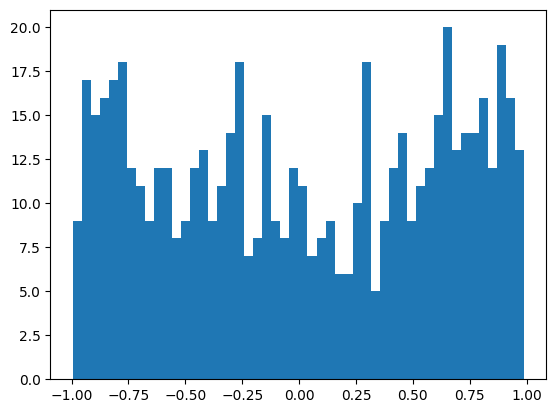

In [81]:
plt.hist(h_snapshot.view(-1).tolist(), 50)

In [76]:
hpreact_snapshot = torch.tensor([[ 6.1881e-01, -1.0676e-01, -8.0316e-01,  3.2100e-01, -1.2711e-01,
         -3.5547e-01, -3.2742e-01, -1.0065e+00,  9.5453e-02,  8.6067e-01,
          1.0056e+00, -5.5943e-01,  4.8107e-01, -1.4054e-01,  6.7636e-02,
          2.2299e-01, -5.9025e-01, -2.4985e-01, -2.5399e-01,  6.9279e-01,
         -2.4016e-01, -4.8388e-01, -1.1128e-01,  1.6186e+00,  4.4863e-01,
         -8.7920e-01,  6.4707e-01, -9.2891e-01, -1.3659e-03,  3.3791e-01,
         -9.3037e-01,  8.1084e-01,  4.6188e-01,  6.5011e-01,  1.5780e+00,
         -1.4526e+00,  1.2009e+00, -1.4924e+00,  1.8118e+00, -4.2859e-01,
          4.6249e-01, -4.3585e-01,  4.6118e-01, -7.8711e-01,  5.9483e-02,
          1.1854e+00,  7.6034e-01,  1.1027e-02, -7.1831e-01, -7.1035e-01,
         -6.2996e-01, -5.6191e-01, -1.1662e+00, -3.7347e-01, -1.6463e+00,
          3.8871e-01, -4.8115e-01, -8.7372e-01, -7.2303e-01, -6.5158e-01,
          7.9586e-01,  3.0402e-01,  6.7870e-02, -4.4847e-01,  4.5925e-01,
          1.4931e-01,  2.1179e-01, -6.4902e-01, -1.2948e+00,  6.8285e-01,
          4.9077e-01,  5.3331e-01, -9.0254e-02, -1.4784e-01,  3.5615e-01,
          7.0656e-01,  1.6674e+00,  9.8045e-02,  5.1156e-01,  6.5396e-01,
          8.4188e-01,  8.6785e-01, -7.8338e-01, -1.2553e+00,  1.2599e+00,
         -1.2644e+00,  2.2238e-01, -3.8569e-01, -3.4587e-01, -3.2539e-01,
         -2.7826e-01,  1.4913e+00, -9.7925e-01,  1.1602e+00, -1.0591e+00,
          9.3064e-01, -7.5126e-01, -1.0032e+00, -7.2517e-01, -1.2008e+00,
         -6.3508e-01,  6.9705e-01,  4.6473e-01, -1.8063e+00, -8.2950e-01,
          1.8216e+00,  8.9376e-01, -2.7408e-01,  2.3910e+00, -6.7333e-01,
          9.4946e-01,  3.8347e-01, -1.0544e+00,  1.4177e+00, -9.2563e-01,
         -2.2579e+00, -1.5295e-01, -2.6854e-01,  5.6585e-01,  7.3632e-01,
          1.3445e+00,  9.9610e-01, -9.6837e-02, -3.2885e-01, -4.6979e-01,
          7.6174e-02, -1.8828e+00, -4.1092e-01,  1.1966e+00,  1.0537e-01,
         -1.6127e-01, -1.6395e+00, -1.1651e+00,  3.1022e-01, -1.8693e-01,
          3.0160e-01, -1.0354e+00, -8.5701e-01,  2.4737e-01,  7.0387e-01,
         -2.9639e-01, -1.5643e+00, -5.6977e-01,  1.9582e+00, -4.8776e-01,
          1.3178e+00,  3.1761e-01,  1.1633e+00,  1.2204e+00, -1.4491e+00,
         -9.9880e-01,  1.4051e+00,  6.8274e-01,  6.5030e-01, -1.4965e-01,
         -2.0849e-01,  6.9468e-01, -3.1356e-02, -5.0666e-01, -6.1614e-01,
         -9.1369e-02,  7.8749e-01,  1.1788e+00,  6.1550e-01,  1.3559e+00,
          1.1243e+00,  9.1398e-01,  6.0366e-01, -4.4087e-01, -4.1252e-01,
          7.0599e-01, -1.0606e+00, -1.3047e+00,  7.9922e-01, -1.2627e+00,
         -5.5397e-01, -9.7249e-01,  1.2030e+00,  3.7709e-01,  2.8199e-01,
          2.8130e-01, -3.8044e-01,  2.0381e+00, -1.0117e+00,  1.0133e-01,
         -4.5819e-01,  2.0249e+00,  2.9464e-01, -1.5588e+00, -1.2575e+00,
          5.8856e-01, -1.7442e+00, -9.7784e-01, -7.1199e-01,  1.0931e+00,
          2.9959e-01, -1.9877e+00, -3.6288e-01, -2.1980e+00,  1.4124e+00],
        [-1.5166e+00, -1.9482e-01, -1.8536e-01, -2.3265e-01, -1.2193e+00,
         -1.2212e+00,  6.2622e-01,  1.4550e-01, -4.3666e-01,  8.5685e-01,
         -2.6571e-01, -3.0417e-01, -1.0785e+00,  6.3452e-01, -5.2495e-01,
         -9.9381e-01,  9.6975e-01, -8.7476e-01,  7.0468e-01,  1.0381e+00,
         -2.0057e+00, -1.2627e+00, -1.7177e-01, -2.1191e-01,  5.5500e-01,
          7.6004e-01,  1.6955e-02, -4.4027e-01,  1.1327e+00,  1.5958e-01,
          1.3507e+00,  6.8378e-01, -1.4673e-01, -5.6206e-01,  6.2934e-01,
         -3.9428e-01,  7.2437e-03, -1.1130e+00, -1.0129e-01, -1.5744e+00,
          4.2212e-01, -7.7401e-02,  7.4949e-01, -6.5754e-02, -3.7251e-01,
          2.1484e-01, -7.1945e-03, -2.5681e-01,  4.7299e-01,  3.1588e-01,
         -1.9018e-01,  7.4734e-01,  5.1281e-01, -2.2408e-02,  2.6194e-01,
         -4.8480e-03, -3.2075e-01, -3.0263e-01,  3.9798e-01,  8.4292e-01,
          8.3750e-01,  8.6924e-02,  9.6241e-01, -2.6394e-01, -1.3730e+00,
         -5.2483e-01,  9.9859e-01, -3.7035e-02, -1.4347e+00, -2.8342e-01,
          4.1462e-01, -2.3899e-02, -2.8572e-01, -9.8013e-01, -8.8569e-01,
          8.2855e-01,  2.3972e-01, -1.4439e+00, -5.5117e-02,  5.6700e-01,
          7.4855e-01,  8.2384e-01,  5.4881e-01,  1.3083e+00, -5.0203e-01,
          1.8889e-01, -3.1347e-01, -1.4601e-02,  3.3894e-02, -2.7469e-01,
          7.9284e-01,  8.4362e-01, -4.8770e-01, -8.0403e-01,  3.9111e-01,
          4.5641e-01,  2.9157e-01, -8.1500e-01, -1.4303e+00,  5.1696e-02,
         -1.6696e+00,  1.8512e-01, -1.7668e+00, -4.5861e-01,  4.1720e-01,
          7.6600e-01, -6.9812e-01, -1.4964e-01,  9.2765e-01,  1.6611e+00,
          1.5121e-01,  8.0009e-01,  2.6334e-01, -1.3638e+00, -1.5669e+00,
          1.2708e+00, -3.5280e-01, -1.0021e+00, -4.9879e-02,  6.1342e-01,
         -1.7065e-01,  1.0786e+00,  5.8298e-01,  4.6444e-01, -7.3168e-01,
          2.3900e+00,  6.8718e-01, -1.4764e-01,  3.2818e-01, -6.5148e-01,
          1.7764e+00,  1.7841e-01, -2.8588e+00,  1.0792e+00, -1.0769e+00,
         -1.0179e+00, -1.1219e+00, -1.0150e+00, -8.9771e-01, -4.4084e-01,
         -1.1209e+00, -5.0065e-01, -1.7779e+00, -6.6039e-01,  1.0937e+00,
          6.0506e-01, -3.5379e-01,  1.0056e+00,  7.8450e-01, -6.0725e-01,
         -2.6784e-01, -9.3315e-01, -9.1871e-01,  1.5950e+00,  6.5676e-01,
          1.0223e+00,  1.9756e+00, -6.3638e-01, -3.0878e-02,  2.9034e-01,
          8.9413e-01,  2.5626e-01, -2.2668e-01, -3.6488e-01,  3.0814e-01,
         -3.6990e-01, -8.8911e-01, -7.4811e-02, -4.4304e-01, -7.0072e-01,
          8.0679e-01,  2.2887e-01, -1.5210e+00,  1.8830e-02,  1.2223e+00,
         -1.9685e-01, -8.4401e-01, -2.8595e-01, -5.5639e-01, -2.7314e-01,
          1.0472e+00, -1.1233e+00, -1.2189e+00, -3.8235e-01,  1.0369e+00,
          8.0690e-01,  2.4625e-01, -3.7696e-03, -1.3851e+00,  1.3414e+00,
          1.1522e-01,  5.9333e-01,  1.0382e+00,  7.2911e-03, -4.3602e-01,
         -2.9632e-01, -6.2413e-02,  4.9422e-02,  5.4156e-01,  4.7186e-01],
        [ 1.1031e+00,  1.1786e-01,  1.1682e+00,  2.8946e-01,  2.5159e+00,
          3.1748e-01,  5.3759e-01, -3.7152e-01,  6.9969e-01,  1.4723e-01,
         -6.2747e-01,  3.4455e-01,  6.9890e-01,  1.2451e+00, -5.1069e-01,
         -1.7783e+00,  2.4992e+00, -2.1119e-01, -1.0008e+00,  1.5901e+00,
          6.9549e-01,  7.0771e-02,  4.2841e-01, -2.9740e-01, -1.5202e+00,
          2.8235e-01, -1.2973e+00,  4.9515e-01,  7.5617e-01,  1.0055e+00,
         -9.1730e-01, -9.5950e-01, -1.0462e+00, -7.5498e-02, -1.5416e+00,
         -1.4794e-01,  1.1327e+00, -8.4810e-02, -6.3828e-01,  4.8973e-01,
         -1.1068e+00, -1.2936e+00, -9.2583e-01, -1.8441e+00, -4.1269e-01,
         -1.1987e+00, -1.1094e+00, -1.1446e-01,  1.0303e+00,  1.5918e-01,
         -7.2529e-01, -7.7004e-01,  3.0055e-01, -4.2722e-01,  3.1863e-02,
         -2.2319e+00, -2.8006e-01,  2.5421e+00, -1.7967e-02, -1.7610e-01,
         -1.0958e+00,  5.5161e-01, -7.2082e-01, -1.3915e-01,  1.1269e+00,
          1.4354e+00,  6.3552e-01,  6.5204e-01, -8.9749e-01, -4.8987e-01,
          5.1841e-01,  1.0471e+00,  8.9481e-01, -8.0821e-02, -1.2517e+00,
          2.6442e-01,  1.3456e+00, -5.2673e-01, -1.6628e+00,  8.3163e-01,
         -8.0835e-01,  1.5356e+00,  1.6831e+00,  6.5923e-01,  1.4862e-01,
          1.0080e-01,  5.9757e-01, -1.3934e+00,  1.4126e-01, -1.3202e+00,
          1.4214e+00,  1.2044e-02, -1.1742e+00, -1.1735e+00, -6.4034e-01,
         -1.0940e+00, -1.0431e-01, -6.9664e-01,  1.0714e+00, -1.0307e+00,
         -1.3203e-01,  1.2229e+00, -1.0353e+00, -5.8291e-01,  3.4013e-02,
          2.7531e-01, -1.6101e+00, -1.0944e+00, -2.8460e-01, -2.3081e-01,
          7.8420e-01,  3.9135e-01,  3.1420e-01,  1.8416e+00,  1.0114e+00,
         -1.3172e-01,  1.1269e-01,  5.0400e-01,  1.3955e+00, -3.2900e-01,
          6.4801e-01, -6.5237e-01,  1.3639e+00,  3.5004e-01,  5.2761e-01,
         -2.8508e-01, -3.0935e-01, -1.1870e+00, -1.5142e+00,  1.4645e+00,
          9.9217e-01, -8.1632e-01, -4.7832e-01,  4.1037e-01,  1.5670e+00,
         -3.6015e-01, -7.5474e-01,  9.2311e-01,  1.7706e+00,  1.1356e+00,
          1.3603e+00, -2.8691e-01, -3.7903e-01,  9.2076e-01, -6.0722e-01,
          4.0548e-01, -2.3459e+00,  3.6373e-02, -3.8986e-01,  4.7013e-01,
          8.4550e-01,  1.4549e-01,  1.4328e+00,  1.8423e+00,  5.2562e-01,
          2.2973e-01, -5.8125e-01, -4.7139e-01,  1.4242e+00,  1.5657e+00,
          4.8321e-01,  9.2409e-01, -2.6087e-02, -2.1449e+00,  2.7067e-01,
         -3.1949e-01,  1.8870e-01,  1.5784e+00,  4.4166e-01, -1.2111e+00,
         -1.2127e+00, -5.4386e-03,  8.9084e-01,  8.0747e-01, -6.7773e-01,
          1.4304e+00,  1.7572e+00, -1.7009e+00, -1.3671e-01, -1.5865e+00,
          4.9342e-01,  1.2954e-01, -8.9372e-01,  1.7234e+00,  4.6096e-01,
          4.3548e-01,  1.9033e+00, -4.8067e-01,  8.5475e-01, -3.2615e-01,
         -5.7440e-01,  1.3051e+00, -1.1905e+00,  8.6956e-01, -1.4816e-01,
          9.7265e-01,  7.9916e-01,  2.9744e-01,  7.7121e-01,  1.3878e+00]])

(array([ 1.,  0.,  0.,  0.,  1.,  2.,  2.,  1.,  1.,  3.,  5.,  9.,  7.,
         9., 11., 13., 18., 21., 14., 16., 18., 21., 26., 38., 21., 30.,
        26., 24., 18., 26., 28., 21., 29., 23., 19., 16., 17., 12.,  9.,
        13.,  5.,  7.,  5.,  4.,  3.,  2.,  0.,  0.,  2.,  3.]),
 array([-2.85879993, -2.75078194, -2.64276394, -2.53474594, -2.42672794,
        -2.31870995, -2.21069195, -2.10267395, -1.99465595, -1.88663795,
        -1.77861996, -1.67060196, -1.56258396, -1.45456596, -1.34654797,
        -1.23852997, -1.13051197, -1.02249397, -0.91447598, -0.80645798,
        -0.69843998, -0.59042198, -0.48240398, -0.37438599, -0.26636799,
        -0.15834999, -0.05033199,  0.057686  ,  0.165704  ,  0.273722  ,
         0.38174   ,  0.489758  ,  0.59777599,  0.70579399,  0.81381199,
         0.92182999,  1.02984798,  1.13786598,  1.24588398,  1.35390198,
         1.46191998,  1.56993797,  1.67795597,  1.78597397,  1.89399197,
         2.00200996,  2.11002796,  2.21804596,  2.32606396,

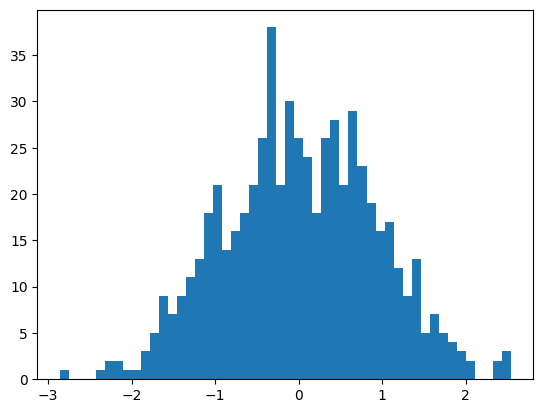

In [77]:
plt.hist(hpreact_snapshot.view(-1).tolist(), 50)

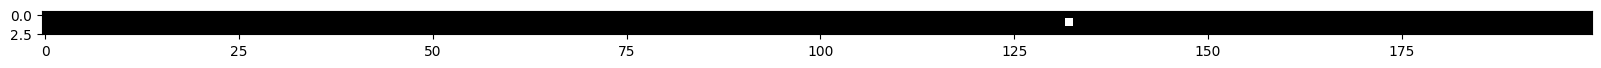

In [82]:
plt.figure(figsize=(20,10))
plt.imshow(h_snapshot.abs() > 0.99, cmap='gray', interpolation='nearest')

Now we have our activated values mostly between -/+0.1 and our preactivated values mostly between -/+2. We also see almost all black for our last visualization because few values have a magnitude greater than 0.99.

## Selecting Initialization Ranges

So far, we've optimized by picking seemingly random (or maybe slightly educated) numbers to bound our layer inputs:
```
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
```

But let's look at ways to do this is a more systematic way.

First let's look at an example:

tensor(0.0235) tensor(1.0076)
tensor(-0.0093) tensor(3.1676)


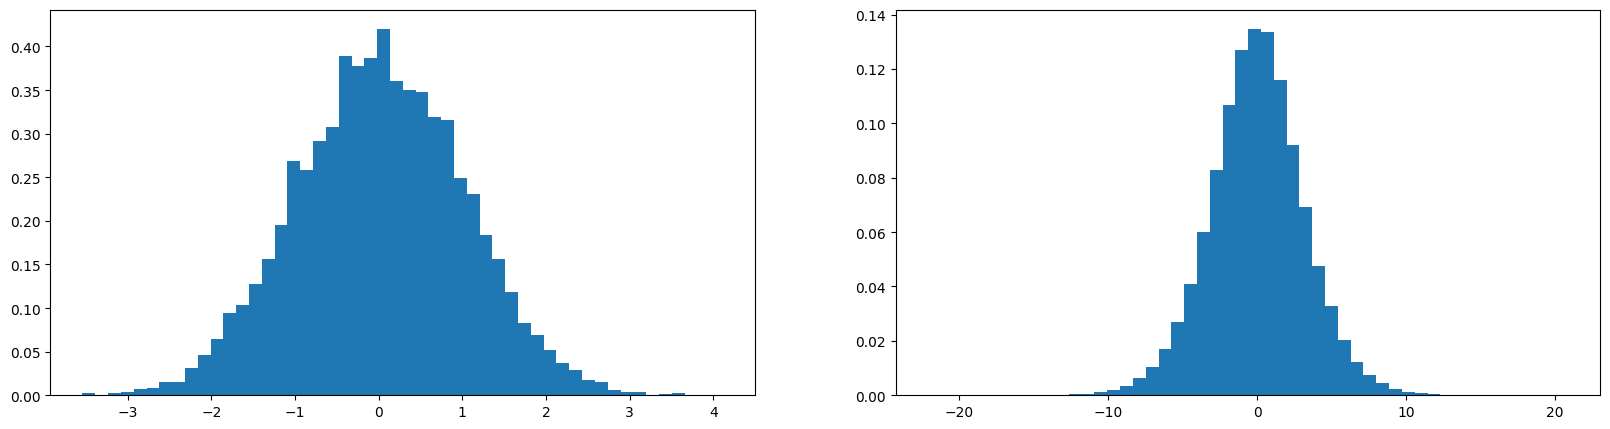

In [94]:
# torch.randn draws from a uniform Gaussian distribution
x = torch.randn(1000,10) # input - 1000 examples, 10 dimensions
w = torch.randn(10,200) # hidden layer - 10 inputs, 200 neurons
y = x @ w # preactivations

# ignoring the bias and the non-linearity for now...

print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);


What we can see is that by simply doing the multiplication we're expanding the Gaussian distribution between `x` and `y`. The mean is about the same, but the standard deviation is about three times bigger now. 

We don't want this, what we really want is "unit Gaussian" throughout the neural net.

So how can we scale `w` to preserve the `y` distribution as a similar Gaussian distribution to `x` with a standard deviation of 1?

We know we have to scale down by dividing (or multiplying by a fraction) to preserve the standard deviation of 1. We may want to precisely preserve the standard deviation to be 1, or we may want to actually include a bit of a gain.

The approach we'll take is explained in [this paper by Kaiming He, et al](https://arxiv.org/pdf/1502.01852.pdf). To keep a unit-noramlized standard deviation we ***divide by the square root of the "fan in"***, where fan in is the number of inputs to the layer. We can also multiply by a gain that is based on the specific type of non-linearity we're using. For a `tanh` the paper recommends a gain of $5/3$. So, in our example above, we divide by the square root of $10$ and multiply by $5/3$.

tensor(-0.0058) tensor(0.9951)
tensor(-0.0052) tensor(1.6629)


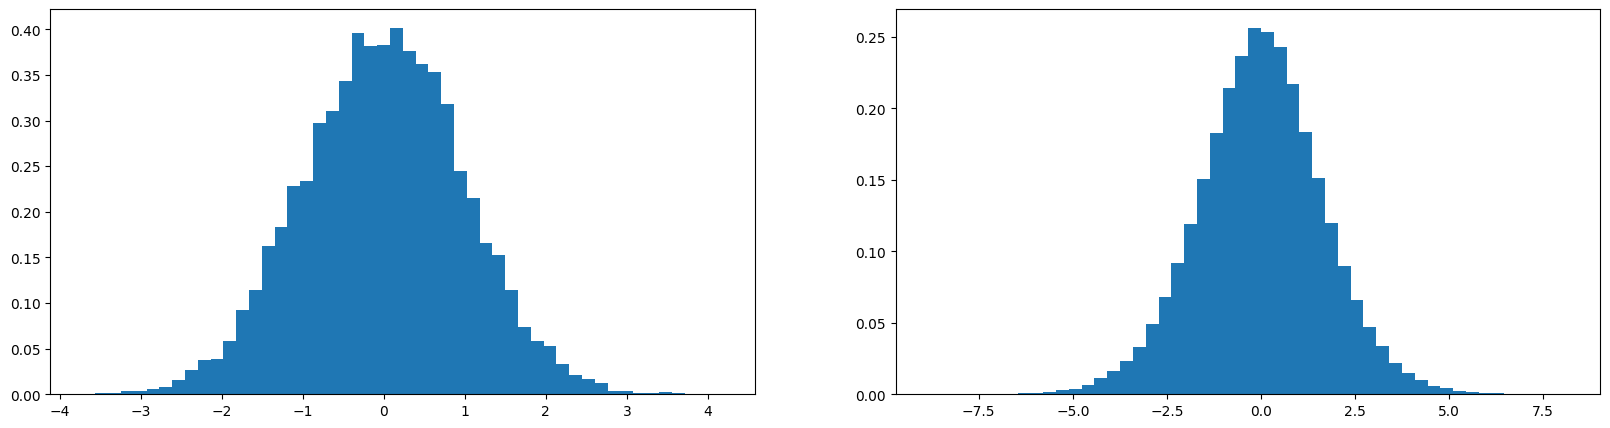

In [95]:
# torch.randn draws from a uniform Gaussian distribution
x = torch.randn(1000,10) # input - 1000 examples, 10 dimensions
w = torch.randn(10,200) * (5/3) / (10**0.5) # hidden layer - 10 inputs, 200 neurons
y = x @ w # preactivations

# ignoring the bias and the non-linearity for now...

print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);


Now you see that the standard deviation of `y` is not quite as big. If we didn't use a gain, it would actually be almost exactly 1, but with the gain, we get about 1.66.

The Kaiming initialization [is available](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_) as part of the PyTorch library.



## Batch Normalization



## Benchmarks

### Previous

These are the best results I captured from where we left off in the last part of this video series. I ran through about 50 scenarios with 100,000 epochs for each run. 

| block_size | num_params | embedding_dimensions | hidden_layer | epochs | initial_lr | batch_size | decay_factor | Training Loss | Dev Loss | Test Loss |
|------------|------------|----------------------|--------------|--------|------------|------------|--------------|---------------|----------|-----------|
|3|17697|10|300|100000|0.5|256|1.5|2.0422|2.1294|2.1337|
|4|32967|20|300|100000|0.5|256|2|1.9828|2.1446|2.1489|
|3|18167|20|200|100000|0.5|256|1.25|2.0357|2.1480|2.1400|
|4|32967|20|300|100000|0.1|256|1.25|2.0988|2.1507|2.1554|


### After Fixing softmax Initialization

Fixing the drastic dropoff in the initial gradient by squashing the B2 and W2 gave us some improved results. I ran 140 scenarios with 100,000 epochs each and these were the top three results.

| block_size | num_params | embedding_dimensions | hidden_layer | epochs | initial_lr | batch_size | decay_factor | Training Loss | Dev Loss | Test Loss |
|------------|------------|----------------------|--------------|--------|------------|------------|--------------|---------------|----------|-----------|
|4|26189|6|500|100000|0.5|128|3|1.9293|2.0882|2.0936|
|4|54567|20|500|100000|0.1|128|1.25|1.9704|2.0943|2.0930|
|4|26189|6|500|100000|0.1|128|1.5|2.0171|2.1023|2.1004|
|3|44567|20|500|100000|0.1|32|2|2.0345|2.1078|2.1037|
|3|29297|10|500|100000|0.1|128|1.5|2.0312|2.1118|2.1124|

### After Fixing tanh Saturation


| block_size | num_params | embedding_dimensions | hidden_layer | epochs | initial_lr | batch_size | decay_factor | Training Loss | Dev Loss | Test Loss |
|------------|------------|----------------------|--------------|--------|------------|------------|--------------|---------------|----------|-----------|
|4|54567|20|500|100000|0.1|32|1.5|1.8862|2.0207|2.0194|
|4|54567|20|500|100000|0.1|64|2|1.8925|2.0211|2.0206|
|4|54567|20|500|100000|0.1|32|1.25|1.8761|2.0242|2.0237|
|4|54567|20|500|100000|0.1|256|2|1.8785|2.0257|2.0241|
|4|54567|20|500|100000|0.1|128|1.25|1.8379|2.0272|2.0290|